## Sıtkı Efe Kılınç
2312721010


# Genetik Algoritma ile Akıllı Depo Optimizasyonu Projesi

**Ders:** Genetik Algoritmalar / Yapay Zeka
**Konu:** Kısıtlı Optimizasyon Problemi (Akıllı Depo Raf Düzeni)
**Öğrenci Adı:** [Adın Soyadın]
**Numara:** [Numaran]

---

## 1. Problemin Tanımı ve Senaryo
Bir lojistik firması, yeni akıllı deposunda raf yerleşim sistemini optimize etmek istemektedir. Amaç, maliyeti düşürürken taşıma verimini artıracak en uygun **Raf Yüksekliği ($x_1$)** ve **Raf Derinliği ($x_2$)** değerlerini bulmaktır.

### Matematiksel Model
* **Amaç Fonksiyonu (Verim Puanı):**
    $$f(x) = 4x_1 + 3x_2 - 0.5x_1x_2$$
    *(Bu fonksiyonun maksimize edilmesi hedeflenmektedir.)*

* **Değişken Sınırları:**
    * $x_1$ (Yükseklik): $[2, 6]$ metre
    * $x_2$ (Derinlik): $[1.5, 4]$ metre

* **Kısıtlar:**
    * $x_1 + x_2 \le 8$ (Depo tavan yüksekliği ve alan kısıtı)
    * $x_2 \ge 1.5$ (Minimum derinlik kısıtı)

---

## 2. Kullanılan Genetik Algoritma Yöntemleri
Bu problemin çözümünde aşağıdaki genetik operatörler ve stratejiler kullanılmıştır:

1.  **Kodlama (Encoding):** Değişkenler ondalıklı sayı (float) olduğu için **Gerçel Değer Kodlaması (Real-value encoding)** kullanılmıştır.
2.  **Seçilim (Selection):** Popülasyondaki çeşitliliği korumak ve erken yakınsamayı önlemek amacıyla **Turnuva Seçimi (Tournament Selection)** yöntemi tercih edilmiştir.
3.  **Çaprazlama (Crossover):** Sayısal değerlerin ortalamasını alarak yeni bireyler üretmek için **Aritmetik Çaprazlama (Arithmetic Crossover)** kullanılmıştır.
4.  **Mutasyon (Mutation):** Genlere küçük rastgele değerler ekleyen **Gaussian (Uniform) Mutasyon** uygulanmış ve sınırlar `np.clip` fonksiyonu ile korunmuştur.
5.  **Kısıt Yönetimi:** Kısıtları ihlal eden bireyler "öldürülmemiş", bunun yerine **Ceza (Penalty) Fonksiyonu** ile uygunluk puanları düşürülmüştür.
6.  **Elitizm (Elitism):** Her neslin en iyi 2 bireyi bozulmadan bir sonraki nesle aktarılmıştır.

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

# PARAMETRELER VE SABİTLER
POPULATION_SIZE = 50       # Popülasyon büyüklüğü
GENERATIONS = 100          # Kaç nesil dönecek
MUTATION_RATE = 0.1        # Mutasyon ihtimali (%10)
TOURNAMENT_SIZE = 3        # Turnuva seçimi için katılımcı sayısı

# Değişken Sınırları
# x1: Raf Yüksekliği [2, 6]
# x2: Raf Derinliği [1.5, 4] (Sorudaki "x2 >= 1.5" kısıtını buraya gömdük)
BOUNDS_X1 = (2, 6)
BOUNDS_X2 = (1.5, 4)

## 3. Uygunluk (Fitness) ve Kısıt Fonksiyonları
Amaç fonksiyonu ve ceza mekanizması aşağıda tanımlanmıştır. Eğer bir birey $x_1 + x_2 > 8$ kısıtını ihlal ederse, ihlal miktarı kadar ceza puanı düşülür.

In [14]:
# FONKSİYONLAR

def objective_function(x1, x2):
    """
    Formül: y = 4x1 + 3x2 - 0.5*x1*x2
    """
    return 4*x1 + 3*x2 - 0.5*x1*x2

def calculate_fitness(individual):
    """
    Uygunluk (Fitness) hesaplar.
    Eğer kısıtlar aşılırsa, bireye 'Ceza (Penalty)' puanı uygulanır.
    """
    x1 = individual[0]
    x2 = individual[1]

    score = objective_function(x1, x2)

    # KISIT KONTROLÜ
    penalty = 0

    # Kısıt 1: x1 + x2 <= 8 (Depo tavan sınırı)
    if (x1 + x2) > 8:
        excess = (x1 + x2) - 8
        penalty += excess * 100  # İhlal miktarı kadar büyük bir ceza kes

    # Kısıt 2: x2 >= 1.5 (Sınırların içinde zaten kontrol ediliyor ama ek güvenlik)
    if x2 < 1.5:
        penalty += 1000 # Çok büyük ceza (bu birey yaşamamalı)

    # Fitness = Amaç Fonksiyonu - Ceza
    return score - penalty

def create_individual():
    """Rastgele genlere sahip bir birey oluşturur."""
    return [
        random.uniform(BOUNDS_X1[0], BOUNDS_X1[1]),
        random.uniform(BOUNDS_X2[0], BOUNDS_X2[1])
    ]

def create_population():
    """Başlangıç popülasyonunu oluşturur."""
    return [create_individual() for _ in range(POPULATION_SIZE)]

## 4. Genetik Operatörler
* **Turnuva Seçimi:** Rastgele 3 birey seçilip en iyisi alınır.
* **Aritmetik Çaprazlama:** Ebeveynlerin genleri $\alpha$ ağırlığı ile harmanlanır.
* **Mutasyon:** Genlere $\pm 0.5$ aralığında rastgele değişim uygulanır.

In [15]:
# GENETİK OPERATÖRLER (CRITERION 2: Seçilim, Çaprazlama, Mutasyon)

def tournament_selection(population):
    """
    Turnuva Seçimi: Rastgele 'k' birey seç, en iyisini al.
    """
    selected = random.sample(population, TOURNAMENT_SIZE)
    # Fitness değeri en yüksek olanı döndür
    return max(selected, key=calculate_fitness)

def crossover(parent1, parent2):
    """
    Aritmetik Çaprazlama: İki ebeveynin genlerinin ağırlıklı ortalaması.
    alpha: 0 ile 1 arasında rastgele bir sayı.
    """
    alpha = random.random()

    # Çocuk 1
    child1 = [
        alpha * parent1[0] + (1 - alpha) * parent2[0],
        alpha * parent1[1] + (1 - alpha) * parent2[1]
    ]

    # Çocuk 2
    child2 = [
        alpha * parent2[0] + (1 - alpha) * parent1[0],
        alpha * parent2[1] + (1 - alpha) * parent1[1]
    ]

    return child1, child2

def mutate(individual):
    """
    Gaussian Mutasyon: Genlere küçük rastgele değerler ekler/çıkarır.
    """
    if random.random() < MUTATION_RATE:
        # x1 için mutasyon
        individual[0] += random.uniform(-0.5, 0.5)
        # Sınırların dışına çıkarsa düzelt (Clamping)
        individual[0] = np.clip(individual[0], BOUNDS_X1[0], BOUNDS_X1[1])

        # x2 için mutasyon
        individual[1] += random.uniform(-0.5, 0.5)
        # Sınırların dışına çıkarsa düzelt (Clamping)
        individual[1] = np.clip(individual[1], BOUNDS_X2[0], BOUNDS_X2[1])

    return individual

## 5. Algoritmanın Çalıştırılması (Main Loop)
Algoritma belirlenen nesil sayısı kadar çalıştırılır. Her döngüde:
1.  Bireyler uygunluk değerine göre sıralanır.
2.  **Elitizm:** En iyi 2 birey doğrudan yeni nesle aktarılır.
3.  Seçilim, Çaprazlama ve Mutasyon ile yeni bireyler üretilir.
4.  En iyi sonuçlar grafik çizimi için kaydedilir.

In [16]:
# ANA DÖNGÜ

# Başlangıç
population = create_population()
best_fitness_history = [] # Grafik çizimi için kayıt

print(f"Genetik Algoritma Başlatılıyor... Popülasyon: {POPULATION_SIZE}, Nesil: {GENERATIONS}")

for generation in range(GENERATIONS):
    # Mevcut popülasyonu fitness'a göre sırala (En iyi en başta)
    population = sorted(population, key=calculate_fitness, reverse=True)

    # En iyi bireyi kaydet (Elitizm için saklayabiliriz veya sadece loglayabiliriz)
    best_ind = population[0]
    best_score = calculate_fitness(best_ind)
    best_fitness_history.append(best_score)

    # Yeni popülasyon oluşturma
    new_population = []

    # Elitizm: En iyi 2 bireyi aynen yeni nesle aktar (Bozulmalarını engelle)
    new_population.extend(population[:2])

    # Geri kalan popülasyonu üret
    while len(new_population) < POPULATION_SIZE:
        # 1. Seçilim
        p1 = tournament_selection(population)
        p2 = tournament_selection(population)

        # 2. Çaprazlama
        c1, c2 = crossover(p1, p2)

        # 3. Mutasyon
        c1 = mutate(c1)
        c2 = mutate(c2)

        new_population.extend([c1, c2])

    # Fazlalık varsa kırp ve yeni nesli aktif et
    population = new_population[:POPULATION_SIZE]

Genetik Algoritma Başlatılıyor... Popülasyon: 50, Nesil: 100


## 6. Sonuçlar ve Performans Analizi
Algoritmanın çalışması sonucunda elde edilen en iyi raf boyutları ve yakınsama grafiği aşağıdadır.


--- OPTİMİZASYON TAMAMLANDI ---
En İyi Raf Yüksekliği (x1): 6.0000 m
En İyi Raf Derinliği  (x2): 1.8078 m
Maksimum Verim Puanı      : 24.0000
Kısıt Kontrolü (x1+x2)    : 7.8078 <= 8


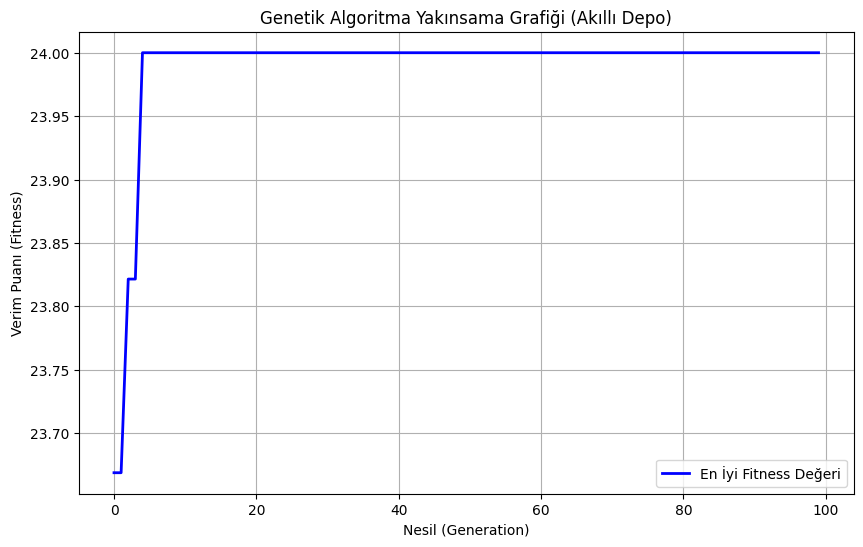

In [17]:
# SONUÇLAR VE GÖRSELLEŞTİRME

best_solution = max(population, key=calculate_fitness)
best_x1, best_x2 = best_solution
final_score = objective_function(best_x1, best_x2)

print("\n--- OPTİMİZASYON TAMAMLANDI ---")
print(f"En İyi Raf Yüksekliği (x1): {best_x1:.4f} m")
print(f"En İyi Raf Derinliği  (x2): {best_x2:.4f} m")
print(f"Maksimum Verim Puanı      : {final_score:.4f}")
print(f"Kısıt Kontrolü (x1+x2)    : {best_x1 + best_x2:.4f} <= 8")

# Grafik Çizimi
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label='En İyi Fitness Değeri', color='blue', linewidth=2)
plt.title('Genetik Algoritma Yakınsama Grafiği (Akıllı Depo)')
plt.xlabel('Nesil (Generation)')
plt.ylabel('Verim Puanı (Fitness)')
plt.grid(True)
plt.legend()
plt.show()